#FIR Colors of the BAT AGN

This notebook will look at the FIR colors of the BAT AGN compared to a non-AGN sample, the [Herschel Reference Survey](http://hedam.lam.fr/HRS/) (HRS). Melendez et al 2014 looked at one specific color, 70/160 from PACS photometry and compared it to the KINGFISH and Dwarf Galaxy Survey finding the BAT AGN have essentially the same color as the KINGFISH galaxies. We want to add in the 3 wavebands (250, 350, 500 micron) from SPIRE allowing for many more colors to be analyzed. Herschel Reference Survey photometry are taken from [Ciesla et al 2012](http://adsabs.harvard.edu/abs/2012A%26A...543A.161C) and [Cortese et al 2014](http://adsabs.harvard.edu/abs/2014MNRAS.440..942C). The BAT AGN photometry is contained in CSV files in the 'bat-data' directory and the HRS data contained in the 'hrs-data' directory.

In [39]:
# Import standard modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mpld3
%matplotlib inline
sns.set()

Cortese et al 2014 looked at the relationship between specific colors: 100/160, 100/250, 100/500, 160/500, and 250/500. Unfortunately for the BAT AGN we do not have 100 micron photometry so what we will have to do is extrapolate the HRS data to 70 micron to match the photometry for the BAT AGN. Cortese et al 2014 provides single temperature greybody fits for all of the HRS galaxies, using a fixed $\beta=2$ and letting $\beta$ be free. I will use the $\beta$ free results since they fit the galaxies better than fixing it to get accurate estimates for the 70 micron flux.

The greybody fits from Cortese et al 2014 are contained in a VOT table so we need to use the astropy.io package to extract them.

In [11]:
from astropy.io.votable import parse_single_table
hrs_fits = parse_single_table('../hrs-data/cortese_2014_table3.vot')
hrs_fits_data = hrs_fits.array
hrs_fits_df = pd.DataFrame.from_records(hrs_fits_data, index=hrs_fits_data['HRS'])

In [151]:
# Import the photometry for the HRS galaxies
hrs_data = pd.read_table('../hrs-data/hrs_photometry.txt', delimiter='\t', index_col=0)

# Combine the fits data with the photometry
hrs_data = hrs_data.join(hrs_fits_df)

The equation that we will use to estimate the 70 micron photometry is the following:

$F_{\nu} = \frac{M_{dust}}{D^{2}}\kappa_{\nu_0}\left(\frac{\nu}{\nu_{0}}\right)^{\beta}B_{\nu}(T)$

$\kappa_{\nu_0}$ is the absorption coefficient at $\nu_{0}$. Cortese et al 2014 used $\kappa_{\nu_0} = 0.192$ m$^{2}$ kg$^{-1}$ at $\nu_{0} = 856.5$ GHz (i.e. 350 micron). These values are from [Draine 2003](http://adsabs.harvard.edu/abs/2003ARA%26A..41..241D).

In [50]:
# Calculate 70 micron flux using the single greybody fits
# First test this method by calculating the 100 micron flux and compare to observed 100 micron flux
from astropy.analytic_functions import blackbody_nu
nu_0 = 856.5e9
nu_100 = 3e14/100.0    # 100 micron in frequency units
kappa_0 = 0.192*(10**4)/(10**3)   # kappa_0 in cgs
Msol = 2e33          # solar mass in g

#hrs_data['S70'] = pd.Series(index = hrs_data.index)
test = pd.Series(index=hrs_data.index)
for i in hrs_fits_df.index:
    md = 10**hrs_data.loc[i, 'log_Mdust__beta_free_']*Msol
    dist = (hrs_data.loc[i, 'D']*10**6*3.086e18)**2
    beta = hrs_data.loc[i, 'beta']
    temp = hrs_data.loc[i, 'T_beta_free_']
    
    if ~np.isnan(temp):
        test.loc[i] = (md/dist*kappa_0*(nu_100/nu_0)**beta*blackbody_nu(nu_100, temp)*10**23).value

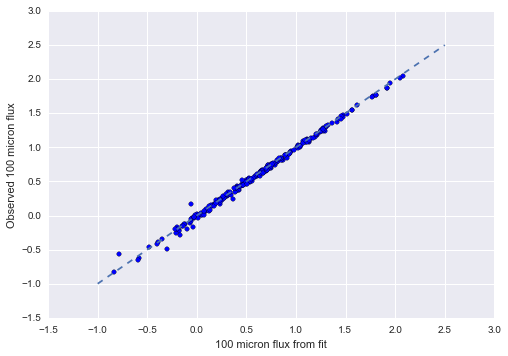

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.log10(test), np.log10(hrs_data['S100']))
ax.plot(np.arange(-1.0, 2.5, .001), np.arange(-1.0, 2.5, 0.001), ls='dashed')
ax.set_xlabel('100 micron flux from fit')
ax.set_ylabel('Observed 100 micron flux')

In [52]:
# Ok everything looks good. Now lets calculate the 70 micron flux
nu_70 = 3e14/70.0

hrs_data['S70'] = pd.Series(index = hrs_data.index)
for i in hrs_fits_df.index:
    md = 10**hrs_data.loc[i, 'log_Mdust__beta_free_']*Msol
    dist = (hrs_data.loc[i, 'D']*10**6*3.086e18)**2
    beta = hrs_data.loc[i, 'beta']
    temp = hrs_data.loc[i, 'T_beta_free_']
    
    if ~np.isnan(temp):
        hrs_data.loc[i, 'S70'] = (md/dist*kappa_0*(nu_70/nu_0)**beta*blackbody_nu(nu_70, temp)*10**23).value

Now that we have the estimated 70 micron flux for all of the HRS galaxies, we can begin to compare the colors with the BAT AGN. First we need to import the BAT AGN Herschel photometry

In [133]:
bat_herschel = pd.read_csv('../../bat-data/bat_herschel.csv', index_col=0)
bat_wise = pd.read_csv('../../bat-data/bat_wise.csv', index_col=0)

I want to reproduce Figure 3 from Cortese et al 2014 to see how the BAT AGN compare to the HRS galaxies. In this figure they plotted the 100/160 color vs. 100/250, 100/500, 160/500, and 250/500 but of course we don't have 100 micron data for the BAT AGN so we will use 70 micron in place of it.

In [152]:
hrs_data['S250'] = hrs_data['S250']*423./465.
hrs_data['S350'] = hrs_data['S350']*751./822.
hrs_data['S500'] = hrs_data['S500']*1587./1769.

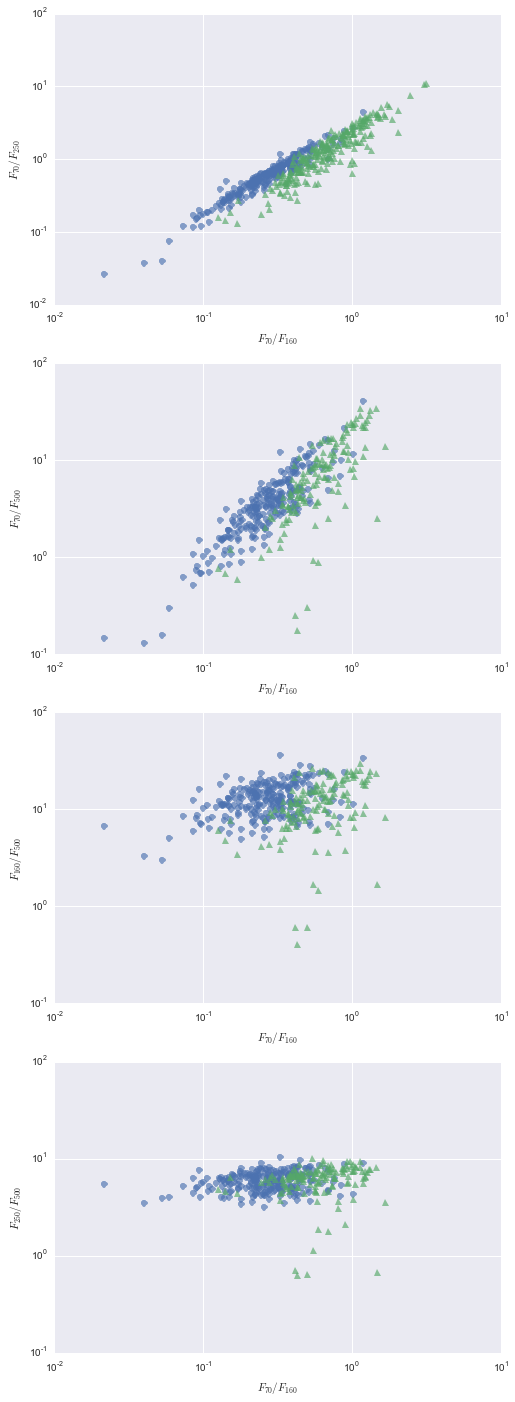

In [99]:
ind_hrs = ((hrs_data['Flag100'] == 1) &
           (hrs_data['Flag160'] == 1) &
           ((hrs_data['Flag250'] == 1) | (hrs_data['Flag250'] == 2)) &
           ((hrs_data['Flag350'] == 1) | (hrs_data['Flag350'] == 2)) &
           ((hrs_data['Flag500'] == 1) | (hrs_data['Flag500'] == 2)))
x_hrs = hrs_data['S70'][ind_hrs]/hrs_data['S160'][ind_hrs]
x_bat = bat_herschel['PACS70']/bat_herschel['PACS160']

fig2 = plt.figure(figsize=(8, 24))
ax1 = fig2.add_subplot(411)
ax1.plot(x_hrs, hrs_data['S70'][ind_hrs]/hrs_data['S250'][ind_hrs]*1000, marker='o', ls='None', alpha=0.65)
ax1.plot(x_bat, bat_herschel['PACS70']/bat_herschel['PSW'], marker='^', ls='None', alpha=0.65)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$F_{70}/F_{160}$')
ax1.set_ylabel('$F_{70}/F_{250}$')

ax2 = fig2.add_subplot(412)
ax2.plot(x_hrs, hrs_data['S70'][ind_hrs]/hrs_data['S500'][ind_hrs]*1000, marker='o', ls='None', alpha=0.65)
ax2.plot(x_bat, bat_herschel['PACS70']/bat_herschel['PLW'], marker='^', ls='None', alpha=0.65)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('$F_{70}/F_{160}$')
ax2.set_ylabel('$F_{70}/F_{500}$')

ax3 = fig2.add_subplot(413)
ax3.plot(x_hrs, hrs_data['S160'][ind_hrs]/hrs_data['S500'][ind_hrs]*1000, marker='o', ls='None', alpha=0.65)
ax3.plot(x_bat, bat_herschel['PACS160']/bat_herschel['PLW'], marker='^', ls='None', alpha=0.65)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('$F_{70}/F_{160}$')
ax3.set_ylabel('$F_{160}/F_{500}$')

ax4 = fig2.add_subplot(414)
ax4.plot(x_hrs, hrs_data['S250'][ind_hrs]/hrs_data['S500'][ind_hrs], marker='o', ls='None', alpha=0.65)
ax4.plot(x_bat, bat_herschel['PSW']/bat_herschel['PLW'], marker='^', ls='None', alpha=0.65)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('$F_{70}/F_{160}$')
ax4.set_ylabel('$F_{250}/F_{500}$')

Looking at the top plot we can see that the BAT AGN are pretty distinct from the HRS galaxies. Interestingly the HRS galaxies seem to have fairly small values for the 70/160 color. Lets look at the histogram of the 70/160 color for the the HRS and BAT galaxies.

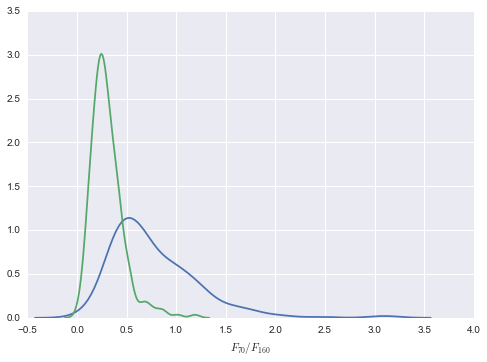

In [108]:
sns.kdeplot(x_bat[np.isfinite(x_bat)])
sns.kdeplot(x_hrs[np.isfinite(x_hrs)])
plt.xlabel('$F_{70}/F_{160}$')

Yeah the HRS galaxies have a very different distribution of 70/160 than the BAT AGN. This seems to be at odds with what Marcio found when comparing the 70/160 color between the KINGFISH and BAT AGN. I wonder if I am underestimating the 70 micron flux for the HRS galaxies. KINGFISH actually has all three PACS fluxes so I should compare them with the HRS.

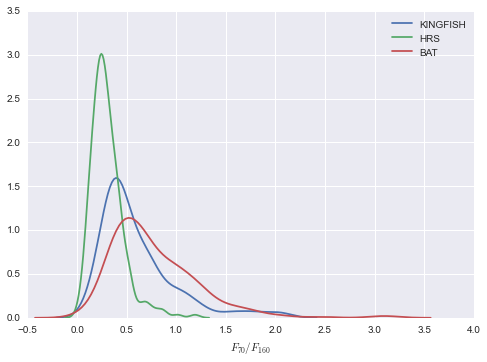

In [110]:
# Import the KINGFISH Data
kf_data = pd.read_table('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/kingfish_herschel_photometry.txt', index_col=0)

# Calculate the KINGFISH 70/160 PACS color
kf_pacs_color1 = kf_data['PACS70']/kf_data['PACS160']

# Plot the KDE with the HRS galaxies
sns.kdeplot(kf_pacs_color1, label='KINGFISH')
sns.kdeplot(x_hrs, label='HRS')
sns.kdeplot(x_bat, label='BAT')
plt.xlabel('$F_{70}/F_{160}$')

Yes the HRS galaxies are definitely lower than the KINGFISH ones which could mean two things:
1. They have intrinsically colder temperatures than the KINGFISH sample.
2. Using a single greybody to fit for the 70 micron flux is wrong.

The way to determine which one is true is to look at the KINGFISH 100/160 color compared to HRS.

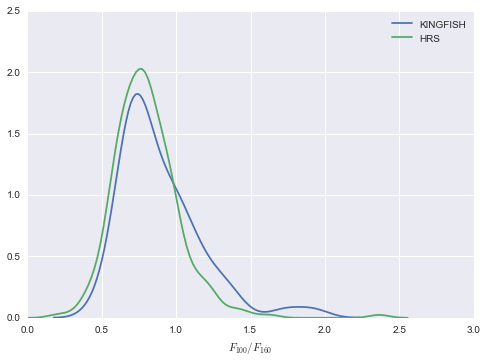

In [112]:
# Plot the KDE with the HRS galaxies
sns.kdeplot(kf_data['PACS100']/kf_data['PACS160'], label='KINGFISH')
sns.kdeplot(hrs_data['S100'][ind_hrs]/hrs_data['S160'][ind_hrs], label='HRS')
plt.xlabel('$F_{100}/F_{160}$')

This pretty definitively shows that by using the single grey body fit to predict the 70 micron flux underestimates it pretty badly. So we can't use that to compare the colors between HRS and BAT. 

Lets look at the 160/250 vs. 350/500 color-color diagram to see if there are differences between the two.

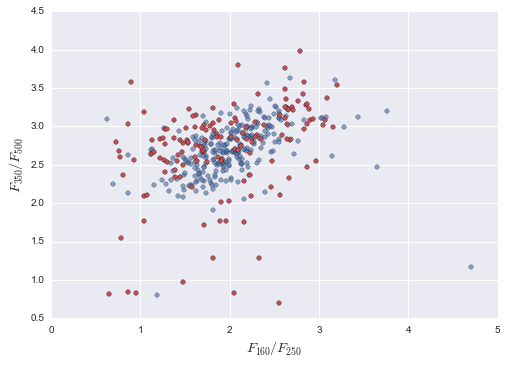

In [182]:
fig3 = plt.figure()
ax1 = fig3.add_subplot(111)
colors = sns.color_palette('deep')

# Theoretical colors given a single temperature grey body
import astropy.constants as apy_c
temps = np.arange(10, 61)
nu160 = 3e14/160.
nu250 = 3e14/250.
nu350 = 3e14/350.
nu500 = 3e14/500.
beta1 = 1.0
beta2 = 2.0
beta3 = 1.5
hp = apy_c.h.cgs.value
kb = apy_c.k_B.cgs.value
f160_f250_beta1 = (nu160/nu250)**(3+beta1)*(np.exp(hp*nu250/kb/temps) - 1)/(np.exp(hp*nu160/kb/temps) - 1)
f350_f500_beta1 = (nu350/nu500)**(3+beta1)*(np.exp(hp*nu500/kb/temps) - 1)/(np.exp(hp*nu350/kb/temps) - 1)
f160_f250_beta2 = (nu160/nu250)**(3+beta2)*(np.exp(hp*nu250/kb/temps) - 1)/(np.exp(hp*nu160/kb/temps) - 1)
f350_f500_beta2 = (nu350/nu500)**(3+beta2)*(np.exp(hp*nu500/kb/temps) - 1)/(np.exp(hp*nu350/kb/temps) - 1)
f160_f250_beta3 = (nu160/nu250)**(3+beta3)*(np.exp(hp*nu250/kb/temps) - 1)/(np.exp(hp*nu160/kb/temps) - 1)
f350_f500_beta3 = (nu350/nu500)**(3+beta3)*(np.exp(hp*nu500/kb/temps) - 1)/(np.exp(hp*nu350/kb/temps) - 1)

#ax1.plot(f160_f250_beta1, f350_f500_beta1, color='k', marker='s', markevery=5, ls='dashed', alpha=0.5)
#ax1.text(f160_f250_beta1[-1]+0.1, f350_f500_beta1[-1], r'$\beta=1.0$', ha='left', va='center')
#ax1.plot(f160_f250_beta2, f350_f500_beta2, color='k', marker='s', markevery=5, ls='dashed', alpha=0.5)
#ax1.text(f160_f250_beta2[-1]+0.1, f350_f500_beta2[-1], r'$\beta=2.0$', ha='left', va='center')
#ax1.plot(f160_f250_beta3, f350_f500_beta3, color='k', marker='s', markevery=5, ls='dashed', alpha=0.5)
#ax1.text(f160_f250_beta3[-1]+0.1, f350_f500_beta3[-1], r'$\beta=1.5$',  ha='left', va='center')

ind_hrs = ((hrs_data['Flag160'] == 1) &
           ((hrs_data['Flag250'] == 1) | (hrs_data['Flag250'] == 2)) &
           ((hrs_data['Flag350'] == 1) | (hrs_data['Flag350'] == 2)) &
           ((hrs_data['Flag500'] == 1) | (hrs_data['Flag500'] == 2)))
ind_bat = (bat_herschel['PACS160'] > 0) & (bat_herschel['PSW'] > 0) & (bat_herschel['PMW'] > 0) & (bat_herschel['PLW'] > 0)

sc_hrs = ax1.scatter(hrs_data['S160'][ind_hrs]/hrs_data['S250'][ind_hrs]*1000, hrs_data['S350'][ind_hrs]/hrs_data['S500'][ind_hrs], c=colors[0], alpha=0.65)
sc_bat = ax1.scatter(bat_herschel['PACS160'][ind_bat]/bat_herschel['PSW'][ind_bat], bat_herschel['PMW'][ind_bat]/bat_herschel['PLW'][ind_bat], c=colors[2])
#sc_kf = ax1.scatter(kf_data['PACS160']/kf_data['SPIRE250'], kf_data['SPIRE350']/kf_data['SPIRE500'], c=colors[4])
ax1.set_xlabel('$F_{160}/F_{250}$', fontsize=14)
ax1.set_ylabel('$F_{350}/F_{500}$', fontsize=14)

mpld3.enable_notebook()
tooltip_bat = mpld3.plugins.PointLabelTooltip(sc_bat, labels=bat_herschel.index[ind_bat].tolist())
tooltip_hrs = mpld3.plugins.PointLabelTooltip(sc_hrs, labels=hrs_data.index[ind_hrs].tolist())
mpld3.plugins.connect(fig3, tooltip_bat)
mpld3.plugins.connect(fig3, tooltip_hrs)

In [180]:
c1 = (hrs_data['S160'][ind_hrs]/hrs_data['S250'][ind_hrs]*1000)
c2 = hrs_data['S350'][ind_hrs]/hrs_data['S500'][ind_hrs]
hrs_data.index[ind_hrs].values[np.argsort(c1.values)]

array([249, 322, 150,   6, 257, 243, 140,  75, 183, 198,  10,   8, 286,
        83, 154,  69, 313, 223, 158, 224, 302, 274, 133,  67,  94, 309,
        76, 261,  64, 128,  22, 252,  80, 317,  39,  54, 141,  41, 213,
       194, 305, 264, 185, 227,  38,  65, 168, 300, 263, 109, 299, 106,
       112, 208, 320, 271, 273,  97, 301, 281, 147, 107, 304,  89, 288,
       115, 311,  73, 255,  61,  92,  15, 319, 314,  62, 131, 276, 279,
       113, 230, 254, 123, 315, 146, 238,  91,  63,  98, 212,  30,  19,
       132, 170, 266, 207, 188,  59, 189, 307, 294, 160, 167, 182, 148,
        47, 297, 124, 117,  34,  78, 199, 151, 118, 193, 127,  70,  88,
       204,  51,  44,  26,  11, 120, 153, 197,  53, 267,  18, 242, 143,
       192, 220,  86, 221,  57, 190,  12, 121,  16, 246, 111, 226,  60,
       323,   1, 169, 122,  24,  29, 172, 270, 237, 232, 130, 163, 259,
        17, 262,  48, 293, 149,  93,  31,  55, 318, 217, 139, 110,  82,
       165, 287,  84, 176,  21,  33, 295,  96, 100,  42, 206,  8

In [181]:
c2.loc[277]

2.6138971550580004